In [12]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers

import pennylane as qml
import numpy as np

import matplotlib.pyplot as plt

#Loading data

In [2]:
mnist = keras.datasets.mnist

# datasets are numpy.ndarrays
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()     

# normalize the pixels from 0 ~ 225 to 0 ~ 1 
X_train, X_test = X_train / 255.0, X_test / 255.0

One hot encoding the labels. We want the labels to be of length cutoff_dim^(num_modes), hence pad with 6 zeros.

In [3]:
def one_hot(labels):  
       
    depth =  4**2                       # 10 classes + 6 zeros for padding
    indices = labels.astype(np.int32)    
    one_hot_labels = np.eye(depth)[indices].astype(np.float32) 
    
    return one_hot_labels

# one-hot encoded labels, each label of length cutoff dimension**2
y_train, y_test = one_hot(Y_train), one_hot(Y_test)

# using only 600 samples for training in this experiment
n_samples = 600
test_samples = 100
X_train, X_test, y_train, y_test = X_train[:n_samples], X_test[:test_samples], y_train[:n_samples], y_test[:test_samples]

In [4]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

In [5]:
X_test.dtype

dtype('float32')

In [6]:
y_train.dtype

dtype('float32')

#1. Classical circuit

Define classical layers using Keras Sequential. Take in 28x28 image matrices, flatten, and output vectors of length 14. 3 hidden layers with ELU activation.

In [7]:
keras.backend.set_floatx('float64')

model = keras.models.Sequential([
                                 layers.Flatten(input_shape = (28,28)),
                                 layers.Dense(128, activation ="relu"),
                                 layers.Dense(64, activation ="relu"),
                                 layers.Dense(32, activation ="relu"),
                                 layers.Dense(14, activation ="relu")
                                ])

# More than a million parameters for the classical circuit
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 14)                462       
                                                                 
Total params: 111,278
Trainable params: 111,278
Non-trainable params: 0
_________________________________________________________________


2. Data encoding circuit

Covert the output vectors from the classical circuit into quantum states by using the entries of the vectors as parameters of continous variable gates.

In [8]:
def data_encoding(x):
    qml.Squeezing(x[3], x[4], wires=0)
    qml.Squeezing(x[9], x[10], wires=1)
    
    qml.Beamsplitter(x[5], x[6], wires=[0,1])
    
    qml.Rotation(x[7], wires=0)
    qml.Rotation(x[8], wires=1)
    
    qml.Displacement(x[1], x[2], wires=0)
    qml.Displacement(x[11], x[12], wires=1)
    
    qml.Kerr(x[0], wires=0)
    qml.Kerr(x[13], wires=1)


#3. Quantum neural network circuit

In [9]:
def qnn_layer(v):
    # Interferometer 1
    qml.Beamsplitter(v[0], v[1], wires=[0,1])
    qml.Rotation(v[2], wires=0)
    qml.Rotation(v[3], wires=1)
    
    # Squeezers
    qml.Squeezing(v[4], 0.0, wires=0)
    qml.Squeezing(v[5], 0.0, wires=1)
    
    # Interferometer 2
    qml.Beamsplitter(v[6], v[7], wires=[0,1])
    qml.Rotation(v[8], wires=0)
    qml.Rotation(v[9], wires=1)
    
    # Bias addition
    qml.Displacement(v[10], 0.0, wires=0)
    qml.Displacement(v[11], 0.0, wires=1)
    
    # Non-linear activation function
    qml.Kerr(v[12], wires=0)
    qml.Kerr(v[13], wires=1)

#4. Initialize parameters

In [10]:
def init_weights(layers, modes, active_sd=0.0001, passive_sd=0.1):
    
    # Number of interferometer parameters: beamsplitter + 2 rotations
    M = 2 + 1 + 1  

    int1_weights = tf.random.normal(shape=[layers, M], stddev=passive_sd)
    s_weights = tf.random.normal(shape=[layers, modes], stddev=active_sd)
    int2_weights = tf.random.normal(shape=[layers, M], stddev=passive_sd)
    dr_weights = tf.random.normal(shape=[layers, modes], stddev=active_sd)
    k_weights = tf.random.normal(shape=[layers, modes], stddev=active_sd)

    weights = tf.concat([int1_weights, s_weights, int2_weights, dr_weights, k_weights], axis=1)
    weights = tf.Variable(weights)

    return weights

5. Quantum device

In [11]:
num_modes = 2
cutoff_dim = 4

# select a devide 
dev = qml.device('strawberryfields.fock', wires=num_modes, cutoff_dim=cutoff_dim) 

@qml.qnode(dev, interface="tf")
def quantum_nn(inputs, var):
    # Encode input x into quantum state
    data_encoding(inputs)

    # iterative quantum layers
    for v in var:
        qnn_layer(v)

    return qml.probs(wires=[0, 1])

6. Hybrid circuit

In [12]:
num_layers = 4

# initialize weights for quantum layers
weigths = init_weights(num_layers, num_modes)

# convert the quantum layer to a Keras layer
shape_tup = weigths.shape
weight_shapes = {'var': shape_tup}
qlayer = qml.qnn.KerasLayer(quantum_nn, weight_shapes, output_dim=4)

# add to the classical sequential model
model.add(qlayer)

7. Loss function and optimizer

In [13]:
opt = keras.optimizers.SGD(lr = 0.02)
model.compile(opt, loss = 'categorical_crossentropy', metrics =['accuracy'])

E:\git_repo_asus\CSE499.06(QML)\venv\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.


8. Training

In [17]:
hybrid = model.fit(X_train.astype('float32'), 
                   y_train.astype('float32'),
                   epochs = 150,
                   batch_size = 64,
                   shuffle = True, 
                   validation_data = (X_test.astype('float32'), y_test.astype('float32')))

10/10 [==============================] - 226s 22s/step - loss: 0.4112 - accuracy: 0.9683 - val_loss: 1.0635 - val_accuracy: 0.7000
Epoch 141/150
10/10 [==============================] - 226s 22s/step - loss: 0.3931 - accuracy: 0.9717 - val_loss: 1.0701 - val_accuracy: 0.6900
Epoch 142/150
10/10 [==============================] - 227s 23s/step - loss: 0.3892 - accuracy: 0.9733 - val_loss: 1.0842 - val_accuracy: 0.7000
Epoch 143/150
10/10 [==============================] - 227s 23s/step - loss: 0.3804 - accuracy: 0.9783 - val_loss: 1.0766 - val_accuracy: 0.7200
Epoch 144/150
10/10 [==============================] - 227s 23s/step - loss: 0.4084 - accuracy: 0.9733 - val_loss: 1.0854 - val_accuracy: 0.6800
Epoch 145/150
10/10 [==============================] - 227s 23s/step - loss: 0.3924 - accuracy: 0.9750 - val_loss: 1.1317 - val_accuracy: 0.6900
Epoch 146/150
10/10 [==============================] - 227s 23s/step - loss: 0.4037 - accuracy: 0.9750 - val_loss: 1.0798 - val_accuracy: 0.6900

KeyboardInterrupt: 

9. Loss and accuracy graphs

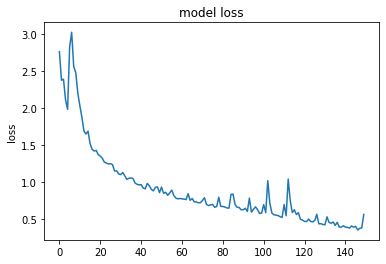

In [ ]:
# ===================================================================================
#                                  Loss History Plot
# ===================================================================================

plt.title('model loss')
plt.plot(hybrid.history['loss'])
plt.ylabel('loss')
plt.show()

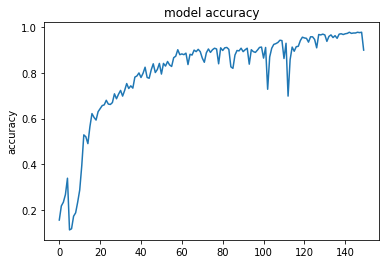

In [18]:
# ===================================================================================
#                                Accuracy History Plot
# ===================================================================================

plt.title('model accuracy')
plt.plot(hybrid.history['accuracy'])
plt.ylabel('accuracy')
plt.show()

In [22]:
from keras.models import save_model

In [33]:
model.save('/models/CVQNN_2_qumode_MNIST.h5')

In [28]:
model.save_weights("../models/CVQNN_2_qumode_MNIST_Weights")

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 14)                462       
                                                                 
 keras_layer (KerasLayer)    (None, 4)                 56        
                                                                 
Total params: 111,334
Trainable params: 111,334
Non-trai

In [115]:
import pickle
# save:
f = open('hybrid_model_history.pckl', 'wb')
pickle.dump(hybrid.history, f)
f.close()

In [ ]:
# # identical to the previous one
# model = load_model('my_model.h5')

In [84]:
mnist = keras.datasets.mnist

# datasets are numpy.ndarrays
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

# normalize the pixels from 0 ~ 225 to 0 ~ 1
X_train, X_test = X_train.reshape(-1, 28 * 28) / 255.0, X_test.reshape(-1, 28 * 28) / 255.0

In [85]:
# using only 600 samples for training in this experiment
n_samples = 600
test_samples = 100
X_train, X_test, y_train, y_test = X_train[:n_samples], X_test[:test_samples], y_train[:n_samples], y_test[
                                                                                                    :test_samples]


In [99]:
classical_model = tf.keras.models.Sequential([
                                 layers.Dense(128, activation='elu', input_shape=(784,)),

                                 layers.Dense(64, activation ="elu"),
                                 layers.Dense(32, activation ="elu"),
                                 layers.Dense(16, activation ="elu"),
                                 layers.Dropout(0.2),
                                 layers.Dense(10, activation ="elu")
                                ])

# More than a million parameters for the classical circuit
classical_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               100480    
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 16)                528       
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_4 (Dense)             (None, 10)                170       
                                                                 
Total params: 111,514
Trainable params: 111,514
Non-trai

In [104]:
classical_model.compile(optimizer='adam',
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

In [105]:
# # Create a callback that saves the model's weights
# cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath="models/Classical Model/training_1/cp.ckpt",
#                                                  save_weights_only=True,
#                                                  verbose=1)

In [106]:
tf.keras.backend.clear_session()

In [107]:
# Train the model with the new callback
classical_model.fit(X_train,
          y_train,
          epochs=150,
          batch_size = 64,
          shuffle = True,
          validation_data=(X_test, y_test))  # Pass callback to training

# This may generate warnings related to saving the state of the optimizer.
# These warnings (and similar warnings throughout this notebook)
# are in place to discourage outdated usage, and can be ignored.

Epoch 1/150


ValueError: in user code:

    File "E:\git_repo_asus\CSE499.06(QML)\venv\lib\site-packages\keras\engine\training.py", line 1051, in train_function  *
        return step_function(self, iterator)
    File "E:\git_repo_asus\CSE499.06(QML)\venv\lib\site-packages\keras\engine\training.py", line 1040, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "E:\git_repo_asus\CSE499.06(QML)\venv\lib\site-packages\keras\engine\training.py", line 1030, in run_step  **
        outputs = model.train_step(data)
    File "E:\git_repo_asus\CSE499.06(QML)\venv\lib\site-packages\keras\engine\training.py", line 890, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "E:\git_repo_asus\CSE499.06(QML)\venv\lib\site-packages\keras\engine\training.py", line 948, in compute_loss
        return self.compiled_loss(
    File "E:\git_repo_asus\CSE499.06(QML)\venv\lib\site-packages\keras\engine\compile_utils.py", line 201, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "E:\git_repo_asus\CSE499.06(QML)\venv\lib\site-packages\keras\losses.py", line 139, in __call__
        losses = call_fn(y_true, y_pred)
    File "E:\git_repo_asus\CSE499.06(QML)\venv\lib\site-packages\keras\losses.py", line 243, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "E:\git_repo_asus\CSE499.06(QML)\venv\lib\site-packages\keras\losses.py", line 1787, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "E:\git_repo_asus\CSE499.06(QML)\venv\lib\site-packages\keras\backend.py", line 5119, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 16) and (None, 10) are incompatible


In [13]:
import pickle

In [14]:
# retrieve:
f = open('history_classical_model.pckl', 'rb')
classical_model_history = pickle.load(f)
f.close()

In [15]:
# retrieve:
f = open('hybrid_model_history.pckl', 'rb')
hybrid_model_history = pickle.load(f)
f.close()

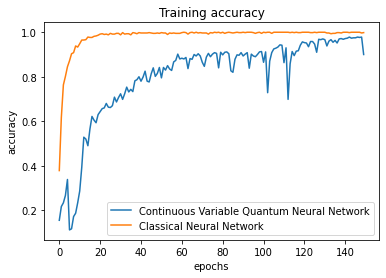

In [122]:
# plt.figure(layout='constrained')
plt.title('Training accuracy')
plt.plot(hybrid.history['accuracy'], label = "Continuous Variable Quantum Neural Network")
plt.plot(classical_model_history['accuracy'], label = "Classical Neural Network")
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend();

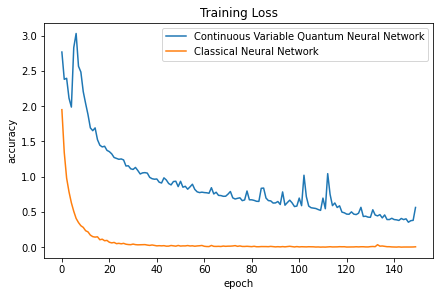

In [125]:
plt.figure( layout='constrained')
plt.title('Training Loss')
plt.plot(hybrid.history['loss'], label = "Continuous Variable Quantum Neural Network")
plt.plot(classical_model_history['loss'], label = "Classical Neural Network")
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend();

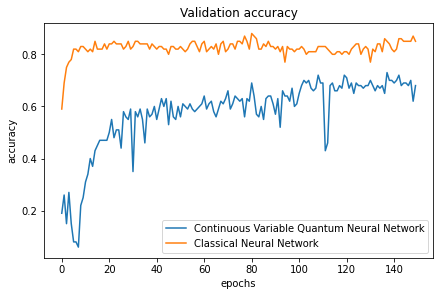

In [126]:
plt.figure( layout='constrained')
plt.title('Validation accuracy')
plt.plot(hybrid.history['val_accuracy'], label = "Continuous Variable Quantum Neural Network")
plt.plot(classical_model_history['val_accuracy'], label = "Classical Neural Network")
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend();

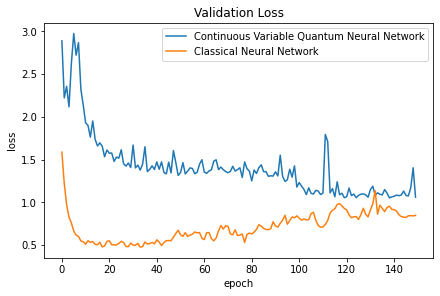

In [17]:
plt.figure( layout='constrained')
plt.title('Validation Loss')
plt.plot(hybrid_model_history['val_loss'], label = "Continuous Variable Quantum Neural Network")
plt.plot(classical_model_history['val_loss'], label = "Classical Neural Network")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend();

In [8]:
import pickle as pkl
import pandas as pd
with open("history_classical_model.pckl", "rb") as f:
    hybrid_history = pkl.load(f)

df = pd.DataFrame(hybrid_history, index=None)


In [9]:
df

,loss,accuracy,val_loss,val_accuracy
0,1.949856,0.378333,1.586466,0.59
1,1.342985,0.616667,1.219926,0.69
2,0.979855,0.763333,0.970446,0.75
3,0.785661,0.801667,0.826683,0.77
4,0.630199,0.845000,0.757933,0.78
...,...,...,...,...
145,0.003540,1.000000,0.821815,0.85
146,0.003116,1.000000,0.842229,0.85
147,0.004132,1.000000,0.843967,0.85
148,0.004680,0.996667,0.839875,0.87


In [10]:
df.to_csv(r'classical_history.csv', index=None)